# Sforecast Example


In [1]:
import sforecast as sf
print(f'sforecast version = {sf.__version__}')
import pandas as pd
import beautifulplots as bp
from datetime import datetime

from xgboost import XGBRegressor
from sklearn.preprocessing import MinMaxScaler

sforecast version = 0.1.0


# Load Data

In [19]:
df_sales = pd.read_csv("../data/Superstore_subcatsales_2017_cdp.csv", parse_dates = ["Order Date"])


df_sales["year"]=df_sales["Order Date"].dt.year
display(df_sales.head(10))

,Order Date,Category,Sub-Category,Sales,Quantity,year
0,2014-01-03,Office Supplies,Paper,16.448,2.0,2014
1,2014-01-04,Office Supplies,Labels,11.784,3.0,2014
2,2014-01-04,Office Supplies,Binders,3.540,2.0,2014
3,2014-01-04,Office Supplies,Paper,0.000,0.0,2014
4,2014-01-04,Office Supplies,Storage,272.736,3.0,2014
5,2014-01-05,Office Supplies,Labels,0.000,0.0,2014
6,2014-01-05,Office Supplies,Binders,0.000,0.0,2014
7,2014-01-05,Office Supplies,Paper,0.000,0.0,2014
8,2014-01-05,Office Supplies,Art,19.536,3.0,2014
9,2014-01-05,Office Supplies,Storage,0.000,0.0,2014


Basic Stats

In [20]:
print(f'date min = {df_sales["Order Date"].min()}')
print(f'date max = {df_sales["Order Date"].max()}')
print(f'N rows (sales) = {df_sales.shape[0]}')
print( f'N Sub-Catetories = {df_sales.groupby("Sub-Category")["Sales"].count().count()} ')

date min = 2014-01-03 00:00:00
date max = 2017-12-30 00:00:00
N rows (sales) = 24431
N Sub-Catetories = 17 


# Sales by Category Time-Series

In [21]:
aggs = {
    "Sales":"sum",
    "Quantity":"sum",
    "year":"last"
    
}

df_catsales = df_sales.groupby(["Order Date" , "Category"]).agg(aggs).reset_index()

df_catsales.head(10)

,Order Date,Category,Sales,Quantity,year
0,2014-01-03,Office Supplies,16.448,2.0,2014
1,2014-01-04,Office Supplies,288.060,8.0,2014
2,2014-01-05,Office Supplies,19.536,3.0,2014
3,2014-01-06,Furniture,2573.820,9.0,2014
4,2014-01-06,Office Supplies,685.340,15.0,2014
5,2014-01-06,Technology,1147.940,6.0,2014
6,2014-01-07,Furniture,76.728,3.0,2014
7,2014-01-07,Office Supplies,10.430,7.0,2014
8,2014-01-07,Technology,0.000,0.0,2014
9,2014-01-08,Furniture,0.000,0.0,2014


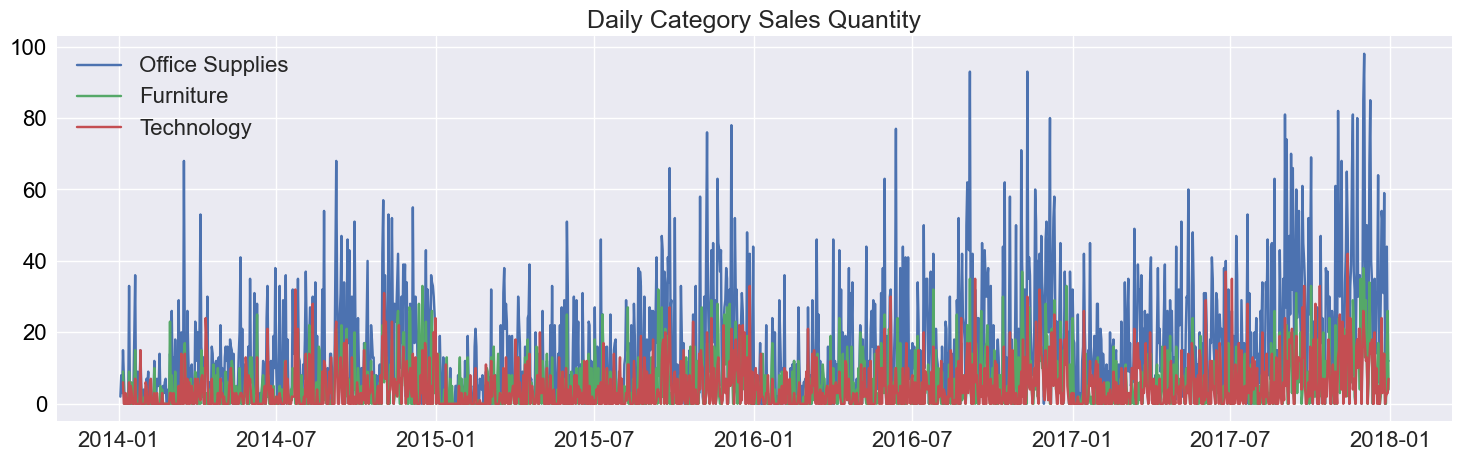

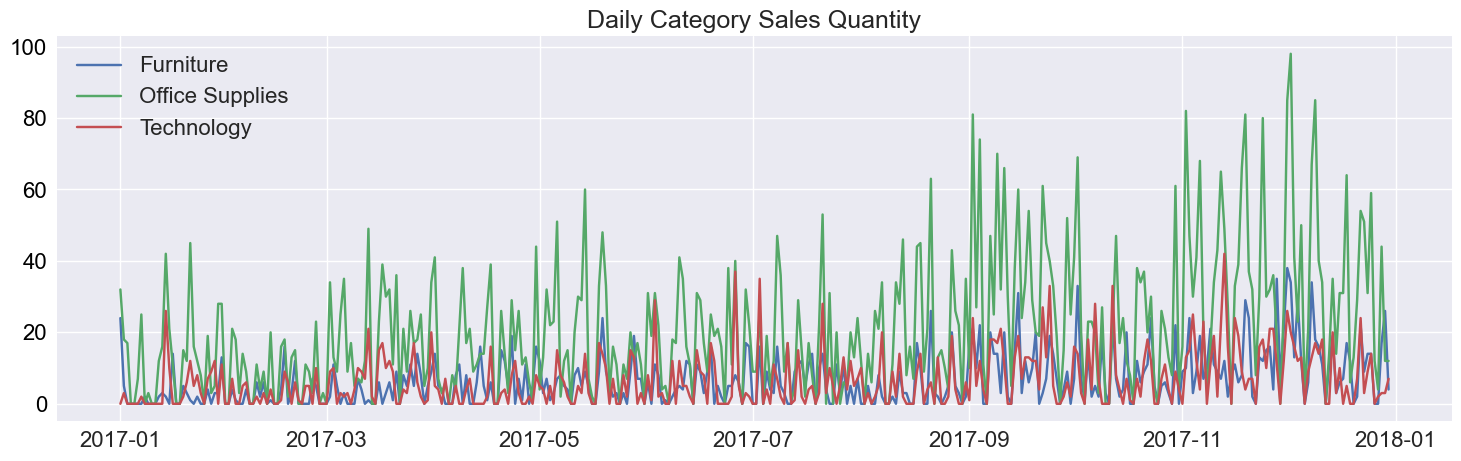

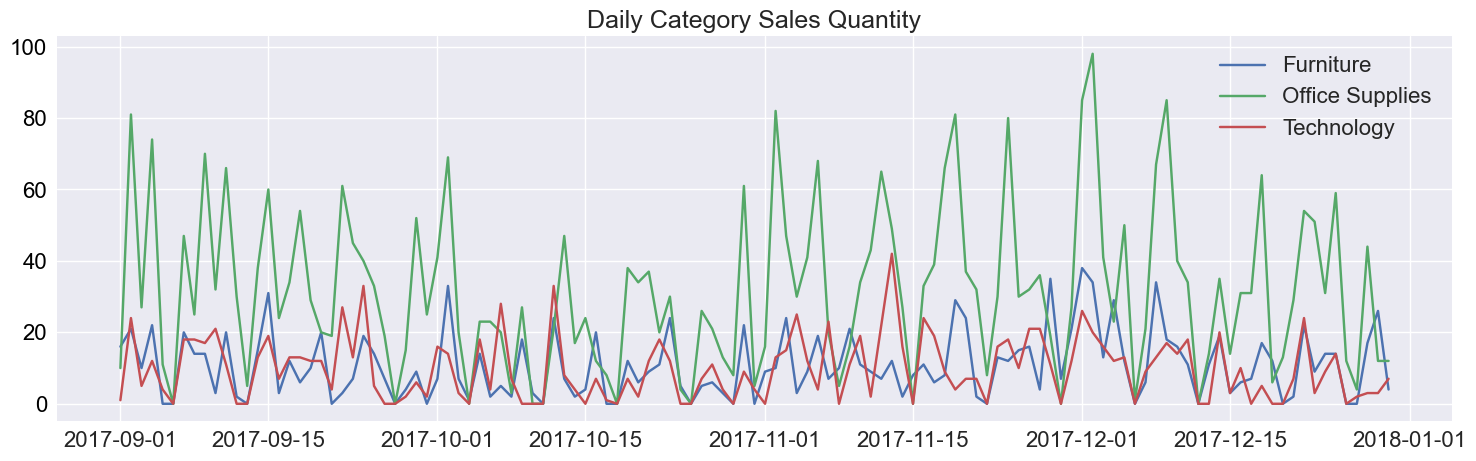

In [24]:

bp.lineplot(df_catsales,"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))


bp.lineplot(df_catsales[df_catsales["year"]==2017],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" , 
            title = "Daily Category Sales Quantity", figsize=(18,5))

d=datetime(2017,9,1)
bp.lineplot(df_catsales[df_catsales["Order Date"]>=d],"Order Date","Quantity",hue="Category",  y_axis_format = ",.0f" ,
            title = "Daily Category Sales Quantity", figsize=(18,5))

# Wide (Multivariate) Format

In [25]:
dfXYw = df_catsales.copy()

def to_flat_columns(hier_cols):
    flat_cols=[]
    for clist in hier_cols:
        for n,ci in enumerate(clist):
            c = ci if n == 0 else c+"_"+ci 
        flat_cols.append(c)
    return flat_cols

dp = "Order Date" # demand period
dfXYw = dfXYw.pivot(index=dp, columns = "Category" , values = ["Quantity" , "Sales"] )
flat_cols = to_flat_columns(dfXYw.columns)
dfXYw.columns = flat_cols 

dfXYw = dfXYw.fillna(0)

dfXYw.head()

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Sales_Furniture,Sales_Office Supplies,Sales_Technology
Order Date,,,,,,
2014-01-03,0.0,2.0,0.0,0.000,16.448,0.00
2014-01-04,0.0,8.0,0.0,0.000,288.060,0.00
2014-01-05,0.0,3.0,0.0,0.000,19.536,0.00
2014-01-06,9.0,15.0,6.0,2573.820,685.340,1147.94
2014-01-07,3.0,7.0,0.0,76.728,10.430,0.00


# Univariate Forecast (w/o Covariates)

In [26]:

dfXY = dfXYw[["Quantity_Furniture"]]


print('dfXY',end="")
display(dfXY.head())

ts_params = {
    "Npred":30,
    "Nhorizon":1,
    "Nlag":30,
    "minmax" :(0,None)}  

y = ["Quantity_Furniture"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

sfuv = sf.sforecast(y = y, ts_parameters=ts_params,model=xgb_model)
df_pred_uv = sfuv.forecast(dfXY)


print(f'\nmetrics = {sfuv.metrics}')
dfXY_pred_uv = dfXY.join(df_pred_uv)
display(dfXY_pred_uv)


dfXY

,Quantity_Furniture
Order Date,
2014-01-03,0.0
2014-01-04,0.0
2014-01-05,0.0
2014-01-06,9.0
2014-01-07,3.0



metrics = {'Quantity_Furniture_pred': {'RMSE': 10.871608563180597, 'MAE': 8.757322120666505}}


,Quantity_Furniture,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,,
2014-01-03,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2017-12-26,0.0,NaN,0.0,4.832206,-4.832206,0.000000,23.030480
2017-12-27,0.0,NaN,0.0,6.921682,-6.921682,0.000000,25.119956
2017-12-28,17.0,NaN,17.0,10.225511,6.774489,0.000000,28.423785


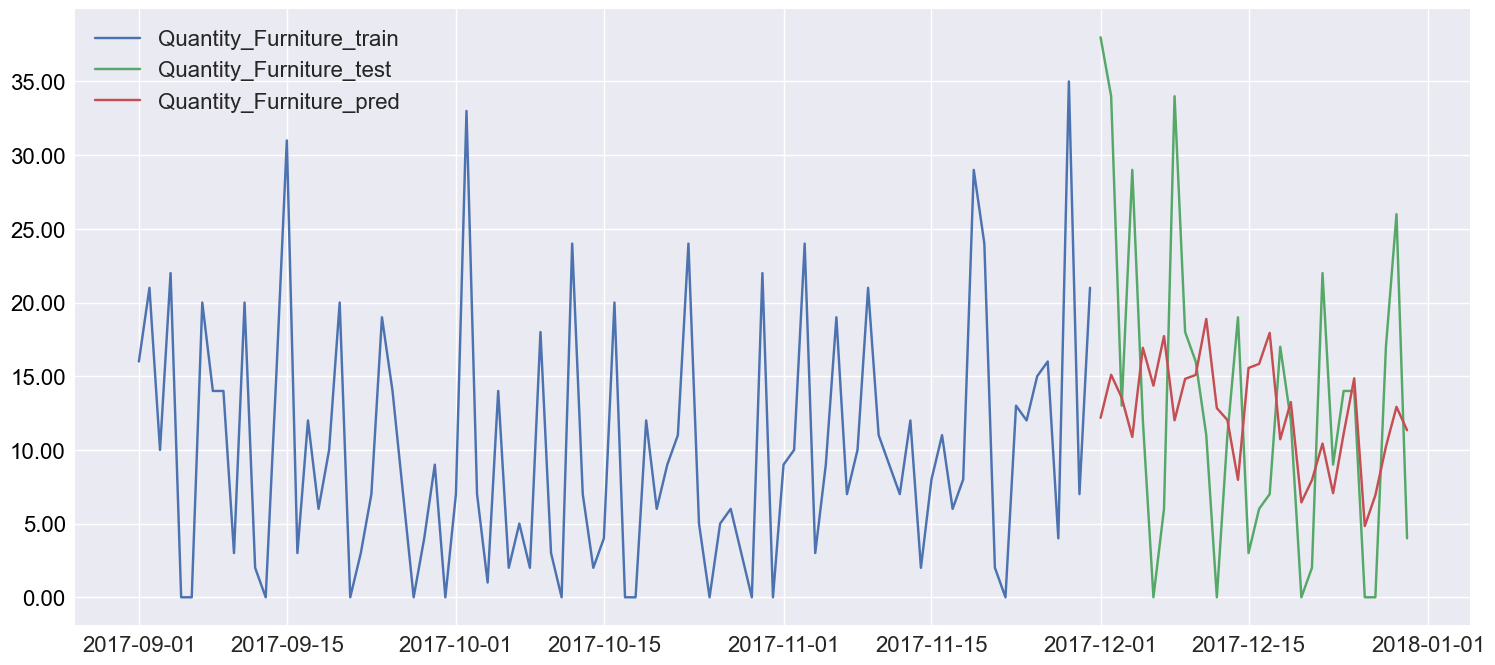

In [27]:

y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfuv = dfXY_pred_uv.reset_index().copy()

yfillbetween = (y+"_pred_lower",y+"_pred_upper")

d=datetime(2017,9,1)
bp.lineplot(dfuv[dfuv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8) , legend=True)

# Univariate Forecast (w Covariates)

In [28]:


dfXY = dfXYw[["Quantity_Furniture","Quantity_Office Supplies", "Quantity_Technology" ]]


print('dfXY',end="")
display(dfXY.head())

ts_params = {
    "Npred":30,
    "Nhorizon":1,
    "Nlag":5,
    "minmax" :(0,None),
    "ar_vars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]} 

y = ["Quantity_Furniture"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

sfuvc = sf.sforecast(y = y, ts_parameters=ts_params,model=xgb_model)
df_pred_uvc = sfuvc.forecast(dfXY)

print(f'\nmetrics = {sfuvc.metrics}')
dfXY_pred_uvc = dfXY.join(df_pred_uvc)
display(dfXY_pred_uvc)

dfXY

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology
Order Date,,,
2014-01-03,0.0,2.0,0.0
2014-01-04,0.0,8.0,0.0
2014-01-05,0.0,3.0,0.0
2014-01-06,9.0,15.0,6.0
2014-01-07,3.0,7.0,0.0



metrics = {'Quantity_Furniture_pred': {'RMSE': 7.69831044644723, 'MAE': 5.4726193189620975}}


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper
Order Date,,,,,,,,,
2014-01-03,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,15.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,12.0,0.0,NaN,0.0,6.232309,-6.232309,1.382412,17.999458
2017-12-27,0.0,4.0,2.0,NaN,0.0,1.187130,-1.187130,0.000000,12.954279
2017-12-28,17.0,44.0,3.0,NaN,17.0,10.697992,6.302008,5.848095,22.465141


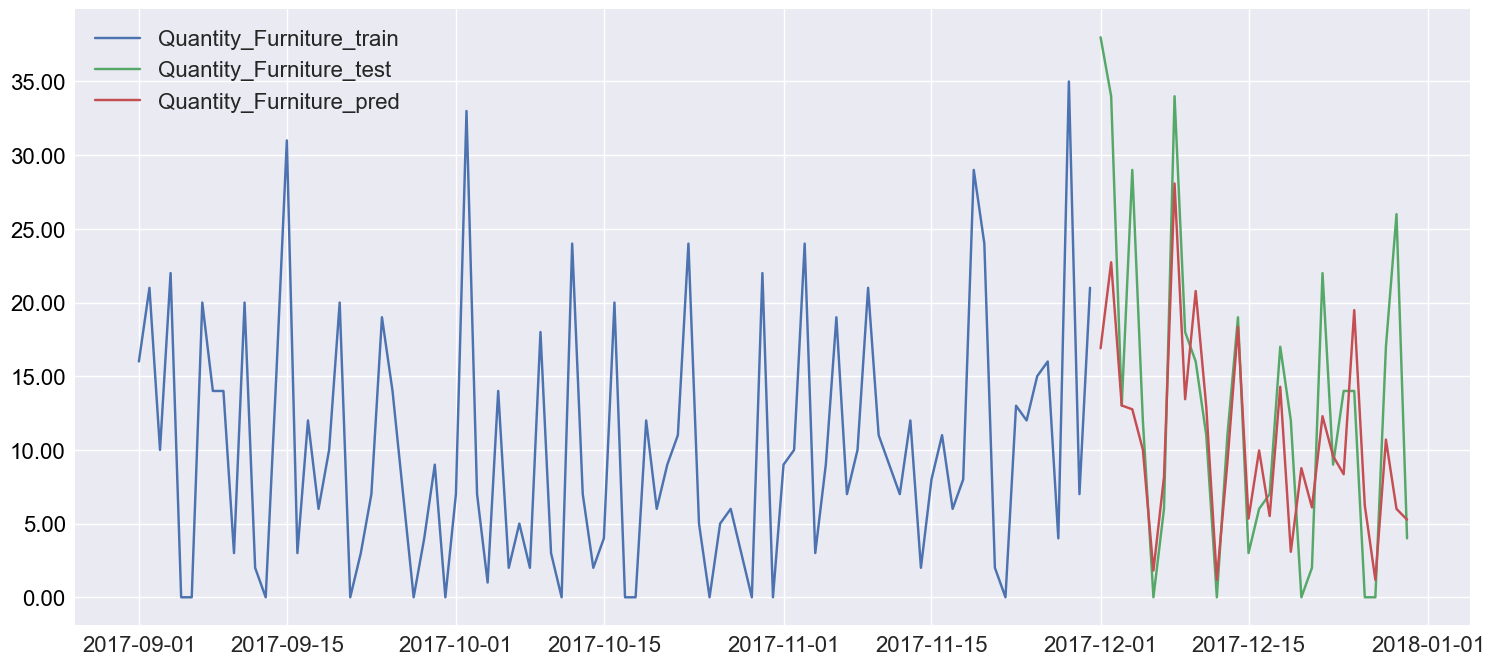

In [29]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfuvc = dfXY_pred_uvc.reset_index().copy()

d=datetime(2017,9,1)
bp.lineplot(dfuvc[dfuvc["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , figsize=(18,8))

# Multivariate Forecast

In [30]:
dfXY = dfXYw[["Quantity_Furniture","Quantity_Office Supplies", "Quantity_Technology" ]]


print('dfXY',end="")
display(dfXY.head())

ts_params = {
    "Npred":30,
    "Nhorizon":1,
    "Nlag":5,
    "minmax" :(0,None),
    "ar_vars":[ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]} 

y = [ "Quantity_Furniture", "Quantity_Office Supplies", "Quantity_Technology"]

xgb_model = XGBRegressor(n_estimators = 10, seed = 42, max_depth=5) 

sfmv = sf.sforecast(y = y, ts_parameters=ts_params,model=xgb_model)
df_pred_mv = sfmv.forecast(dfXY)

print(f'\nmetrics = {sfmv.metrics}')
dfXY_pred_mv = dfXY.join(df_pred_mv)
display(dfXY_pred_mv)

dfXY

,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology
Order Date,,,
2014-01-03,0.0,2.0,0.0
2014-01-04,0.0,8.0,0.0
2014-01-05,0.0,3.0,0.0
2014-01-06,9.0,15.0,6.0
2014-01-07,3.0,7.0,0.0



metrics = {'Quantity_Furniture_pred': {'RMSE': 7.69831044644723, 'MAE': 5.4726193189620975}, 'Quantity_Office Supplies_pred': {'RMSE': 20.09865494459207, 'MAE': 15.861558059851328}, 'Quantity_Technology_pred': {'RMSE': 6.394247291706323, 'MAE': 4.876913078625997}}


,Quantity_Furniture,Quantity_Office Supplies,Quantity_Technology,Quantity_Furniture_train,Quantity_Furniture_test,Quantity_Furniture_pred,Quantity_Furniture_pred_error,Quantity_Furniture_pred_lower,Quantity_Furniture_pred_upper,Quantity_Office Supplies_train,...,Quantity_Office Supplies_pred,Quantity_Office Supplies_pred_error,Quantity_Office Supplies_pred_lower,Quantity_Office Supplies_pred_upper,Quantity_Technology_train,Quantity_Technology_test,Quantity_Technology_pred,Quantity_Technology_pred_error,Quantity_Technology_pred_lower,Quantity_Technology_pred_upper
Order Date,,,,,,,,,,,,,,,,,,,,,
2014-01-03,0.0,2.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-04,0.0,8.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-05,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-06,9.0,15.0,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-07,3.0,7.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-12-26,0.0,12.0,0.0,NaN,0.0,6.232309,-6.232309,1.382412,17.999458,NaN,...,0.572780,11.427220,0.000000,34.694459,NaN,0.0,2.777763,-2.777763,0.000000,9.059299
2017-12-27,0.0,4.0,2.0,NaN,0.0,1.187130,-1.187130,0.000000,12.954279,NaN,...,18.969105,-14.969105,3.215811,53.090784,NaN,2.0,1.860908,0.139092,0.000000,8.142444
2017-12-28,17.0,44.0,3.0,NaN,17.0,10.697992,6.302008,5.848095,22.465141,NaN,...,31.463343,12.536657,15.710049,65.585022,NaN,3.0,13.434463,-10.434463,2.938298,19.715999


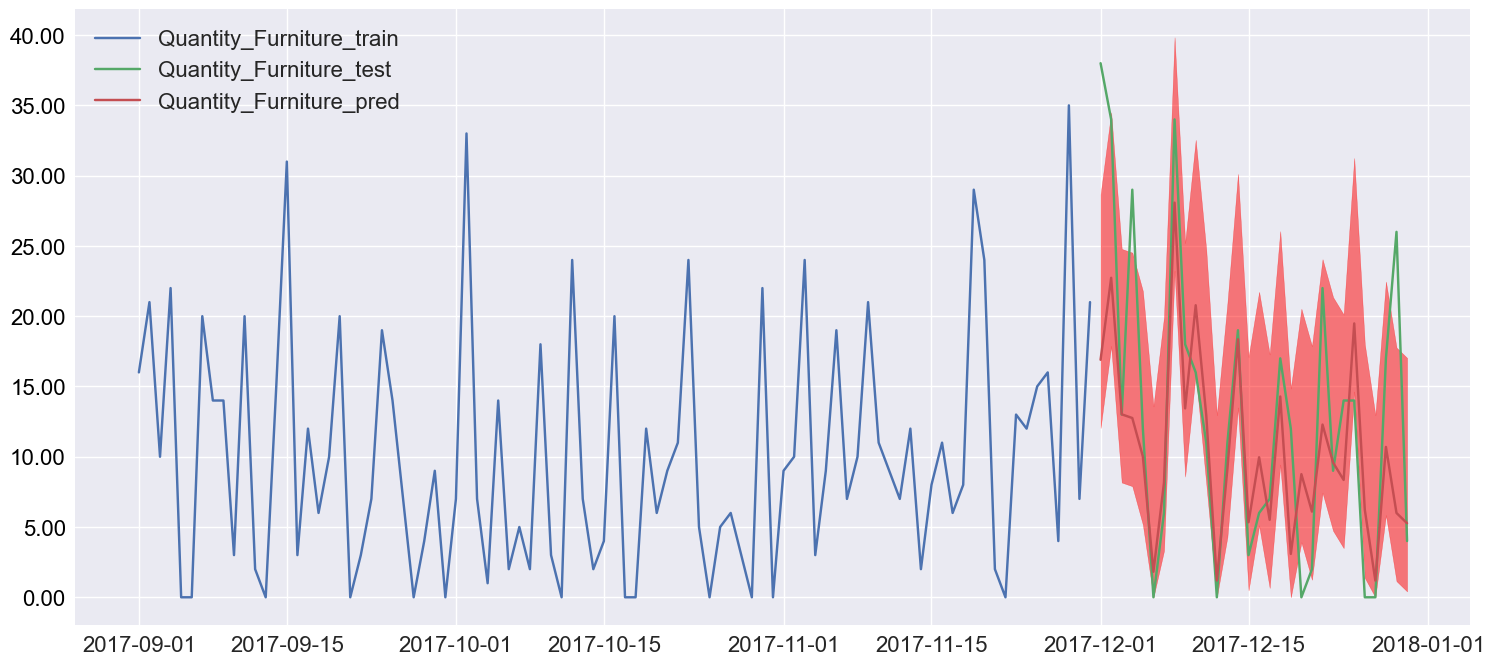

In [31]:
y =  "Quantity_Furniture" 
ytrain = y+"_train"
ytest = y+"_test"
ypred = y+"_pred"
error = y+"_pred_error"
dfmv = dfXY_pred_mv.reset_index().copy()

yfillbetween = (y+"_pred_lower",y+"_pred_upper")

d=datetime(2017,9,1)
bp.lineplot(dfmv[dfmv["Order Date"]>=d], x= "Order Date", y=[ytrain, ytest , ypred] , yfb=yfillbetween, figsize=(18,8) , legend=True)